In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks



In [2]:
# Updated file path (ensure this path is correct on your computer)
file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Science Projects\Double Slit\TimeDrivenQuantumCollapse\data\Data_D2He_DoubleSlitScattering.xlsx"




In [3]:
# Check if file exists before proceeding
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

try:
    xl = pd.ExcelFile(file_path)
except Exception as e:
    raise IOError(f"Error loading Excel file: {e}")



In [4]:
# Retrieve sheet names (each representing a scattering angle)
angles = xl.sheet_names

data_dict = {}
for angle in angles:
    try:
        # Attempt to parse each sheet
        data = xl.parse(angle)
        data_dict[angle] = data
    except Exception as e:
        print(f"Error parsing sheet {angle}: {e}")

def analyze_fringe_spacing(data, angle, save_plot=False, plot_dir="plots"):
    """
    Detects peaks in the double-slit experiment data and calculates fringe spacing.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the experiment data.
        angle (str): The label for the current dataset (scattering angle).
        save_plot (bool): Whether to save the generated plot as an image.
        plot_dir (str): Directory where to save the plot if save_plot is True.
        
    Returns:
        np.array: Array of fringe spacings (differences in degrees between detected peaks).
    """
    # Try to use column headers if available, else default to first two columns
    if 'Scattering Angle' in data.columns and 'Counts' in data.columns:
        x = data['Scattering Angle']
        y = data['Counts']
    else:
        x = data.iloc[:, 0]  # Assumes first column is scattering angle
        y = data.iloc[:, 1]  # Assumes second column is intensity/counts

    # Detect peaks using both a height threshold and a prominence filter to avoid noise.
    # Adjust the prominence parameter as needed.
    height_threshold = np.mean(y)
    peaks, properties = find_peaks(y, height=height_threshold, prominence=0.5)
    
    if len(peaks) < 2:
        print(f"Not enough peaks detected for angle {angle}.")
        return np.array([])

    fringe_spacing = np.diff(x.iloc[peaks])  # Calculate differences between consecutive peak positions

    # Plot the data and mark detected peaks
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, label=f"{angle}° Data", marker="o", linestyle="-")
    plt.plot(x.iloc[peaks], y.iloc[peaks], "ro", label="Detected Peaks")
    plt.xlabel("Scattering Angle (°)")
    plt.ylabel("Counts (Intensity)")
    plt.title(f"Interference Pattern at {angle}°")
    plt.legend()
    plt.grid(True)
    
    # Optionally save the plot instead of (or in addition to) displaying it
    if save_plot:
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
        plot_filename = os.path.join(plot_dir, f"interference_pattern_{angle}.png")
        plt.savefig(plot_filename, dpi=300)
        print(f"Plot saved to {plot_filename}")
    else:
        plt.show()
    
    plt.close()  # Close the figure to free memory
    return fringe_spacing



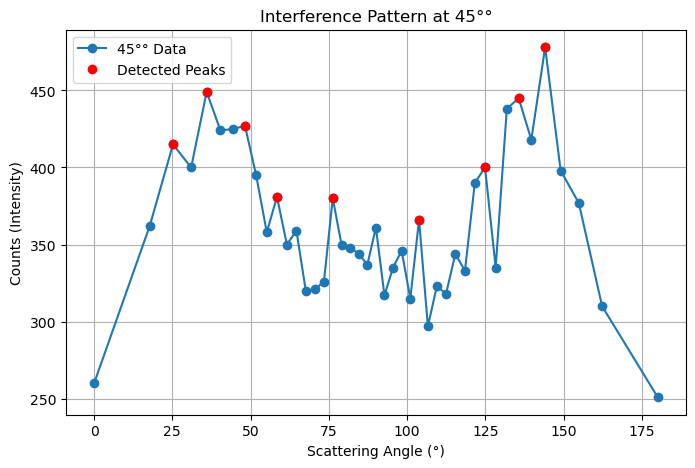

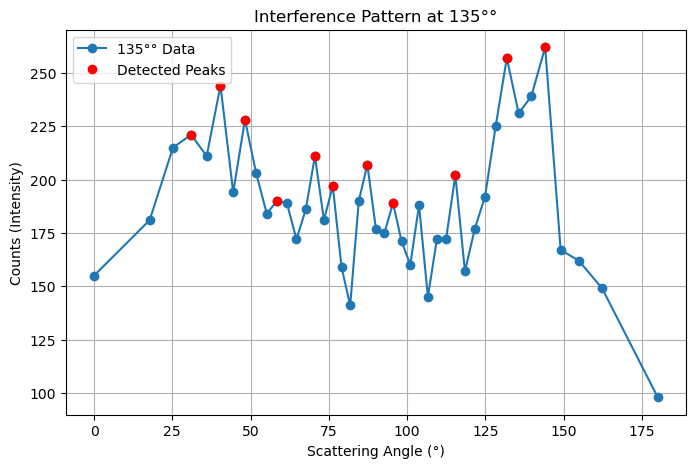

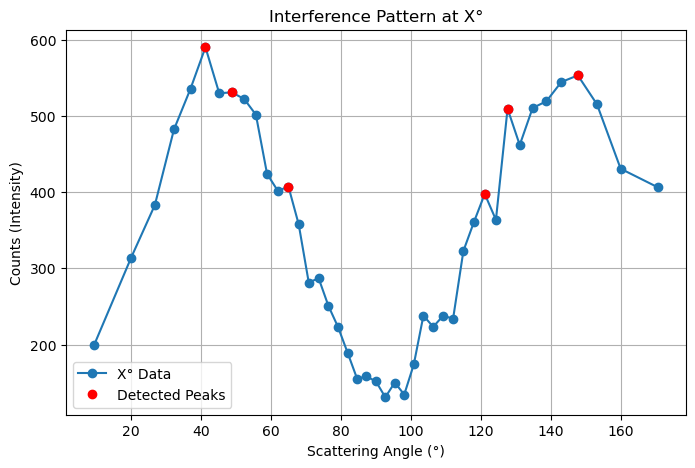


Fringe Spacing Results:
Angle 45°°: 14.855 ± 6.241 degrees
Angle 135°°: 11.305 ± 4.002 degrees
Angle X°: 21.292 ± 18.148 degrees


In [5]:
# Analyze each dataset and store results
fringe_spacing_results = {}
for angle, data in data_dict.items():
    spacing = analyze_fringe_spacing(data, angle)
    fringe_spacing_results[angle] = spacing

# Print the fringe spacing results
print("\nFringe Spacing Results:")
for angle, spacing in fringe_spacing_results.items():
    if spacing.size > 0:
        mean_spacing = spacing.mean()
        std_spacing = spacing.std()
        print(f"Angle {angle}°: {mean_spacing:.3f} ± {std_spacing:.3f} degrees")
    else:
        print(f"Angle {angle}°: Not enough peaks detected to compute fringe spacing.")

## Fringe Spacing vs Wavelength

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit




In [7]:
# Load quantum coherence data
file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Science Projects\Double Slit\TimeDrivenQuantumCollapse\data\Fig3_panel_a.csv"
df_coherence = pd.read_csv(file_path)



In [8]:
# Preview the first few rows to check for header issues
print(df_coherence.head())



       time (s) →             0.52083    0.625  0.72917  0.83333   0.9375  \
0  frequency (Hz)  FFT amplitude (mV)      NaN      NaN      NaN      NaN   
1          244.16             0.51026  0.50342  0.45619  0.38473  0.27487   
2           243.2             0.51222  0.39207  0.35706  0.39469  0.39123   
3          242.24             0.46887  0.29740  0.25724  0.34629  0.40399   
4          241.28             0.49161  0.26096  0.23018  0.34317  0.36448   

    1.0417   1.1458     1.25   1.3542  ...   5.4167   5.5208    5.625  \
0      NaN      NaN      NaN      NaN  ...      NaN      NaN      NaN   
1  0.17197  0.32546  0.43742  0.52119  ...  0.46347  0.46454  0.44243   
2  0.34942  0.25000  0.23682  0.41559  ...  0.13921  0.39070  0.50690   
3  0.40697  0.37867  0.38439  0.42063  ...  0.39814  0.47594  0.55100   
4  0.35837  0.36551  0.36537  0.34172  ...  0.27659  0.39802  0.52067   

    5.7292   5.8333   5.9375   6.0417  6.1458    6.25  6.3542  
0      NaN      NaN      NaN      

In [9]:
# Identify actual headers and real data start point
df_coherence.columns = df_coherence.iloc[0]  # Use first row as headers
df_coherence = df_coherence[1:].reset_index(drop=True)  # Remove old header row

# Ensure numerical values
df_coherence = df_coherence.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df_coherence.dropna(inplace=True)

# Extract time and coherence amplitude (adjust column selection as needed)
time = df_coherence.iloc[:, 0]  # First column is Time (s)
coherence = df_coherence.iloc[:, 1]  # Second column is FFT amplitude (mV)

In [10]:
# Ensure the column names are correctly identified
df_coherence.columns = df_coherence.iloc[0]  # Use first row as header
df_coherence = df_coherence[1:].reset_index(drop=True)  # Remove the old header row



In [11]:
# Convert columns to numeric (handles string issues)
df_coherence = df_coherence.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (caused by non-numeric entries)
df_coherence.dropna(inplace=True)

# Extract relevant columns
time = df_coherence.iloc[:, 0]  # Time in seconds
coherence = df_coherence.iloc[:, 1]  # FFT amplitude or coherence probability



In [12]:

# Define exponential decay function
def exponential_decay(t, lambda_collapse, A):
    return A * np.exp(-lambda_collapse * t)

# Fit the data to the decay function
params, covariance = curve_fit(exponential_decay, time, coherence, p0=[0.1, max(coherence)])
lambda_fit, A_fit = params

# Generate fit curve
fit_curve = exponential_decay(time, lambda_fit, A_fit)



C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


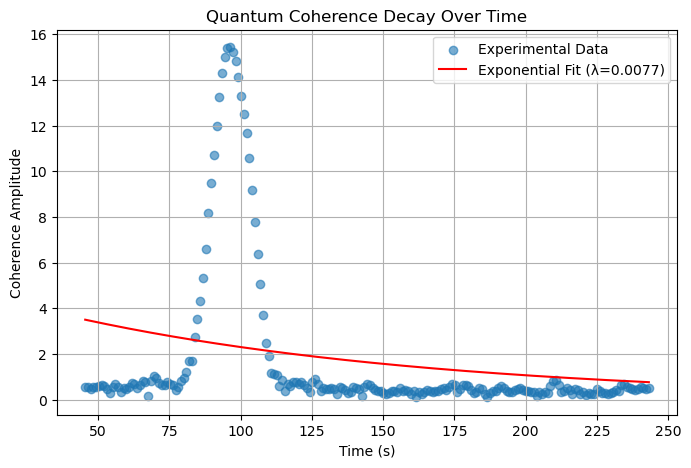

Fitted Collapse Rate (λ): 0.007680 per second


In [13]:
# Plot experimental vs. fitted data
plt.figure(figsize=(8, 5))
plt.scatter(time, coherence, label="Experimental Data", alpha=0.6)
plt.plot(time, fit_curve, color='red', label=f"Exponential Fit (λ={lambda_fit:.4f})")
plt.xlabel("Time (s)")
plt.ylabel("Coherence Amplitude")
plt.title("Quantum Coherence Decay Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Print decay constant
print(f"Fitted Collapse Rate (λ): {lambda_fit:.6f} per second")


## Simulated Youngs Data

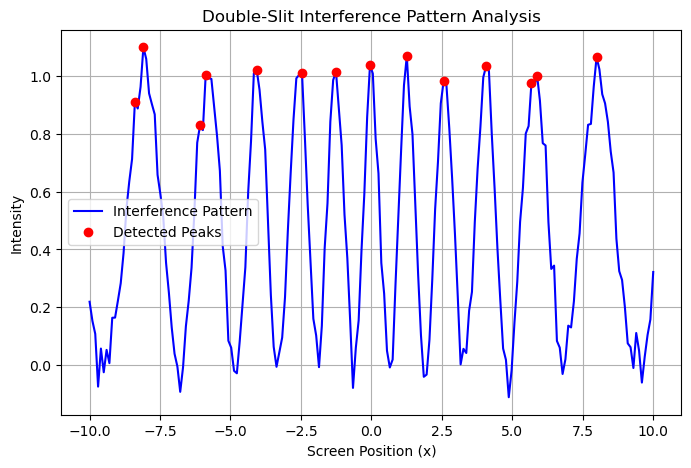

Average Fringe Spacing: 1.260 ± 0.624


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the simulated double-slit dataset
file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Science Projects\Double Slit\TimeDrivenQuantumCollapse\data\simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Interference Pattern", color="blue")
plt.plot(x[peaks], y[peaks], "ro", label="Detected Peaks")
plt.xlabel("Screen Position (x)")
plt.ylabel("Intensity")
plt.title("Double-Slit Interference Pattern Analysis")
plt.legend()
plt.grid(True)
plt.show()

# Print fringe spacing statistics
print(f"Average Fringe Spacing: {np.mean(fringe_spacing):.3f} ± {np.std(fringe_spacing):.3f}")



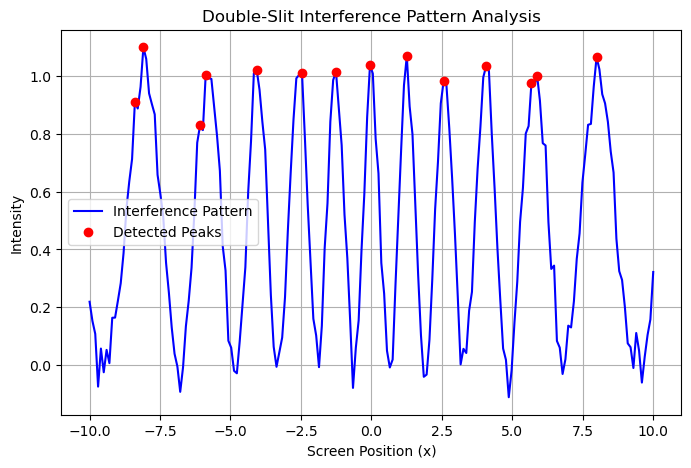

Average Fringe Spacing: 1.260 ± 0.624


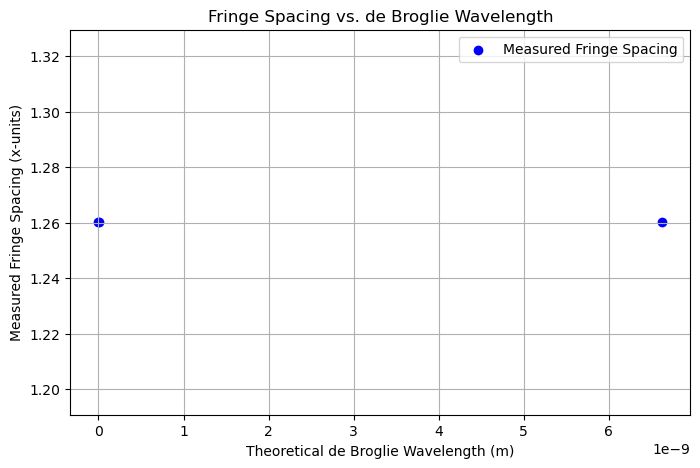

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5  # Assumed velocity (m/s)

# Experimentally measured fringe spacing
file_path = "../data/simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Example masses (kg) for different conditions
particle_masses = [1e-30, 1e-27, 1e-24]  # Adjust as needed

debroglie_wavelengths = [h / (m * v) for m in particle_masses]  # Compute theoretical wavelengths

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Interference Pattern", color="blue")
plt.plot(x[peaks], y[peaks], "ro", label="Detected Peaks")
plt.xlabel("Screen Position (x)")
plt.ylabel("Intensity")
plt.title("Double-Slit Interference Pattern Analysis")
plt.legend()
plt.grid(True)
plt.show()

# Print fringe spacing statistics
print(f"Average Fringe Spacing: {np.mean(fringe_spacing):.3f} ± {np.std(fringe_spacing):.3f}")

# Plot Fringe Spacing vs. de Broglie Wavelength
plt.figure(figsize=(8, 5))
plt.scatter(debroglie_wavelengths, [np.mean(fringe_spacing)] * len(debroglie_wavelengths), label="Measured Fringe Spacing", color="blue")
plt.xlabel("Theoretical de Broglie Wavelength (m)")
plt.ylabel("Measured Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. de Broglie Wavelength")
plt.legend()
plt.grid(True)
plt.show()


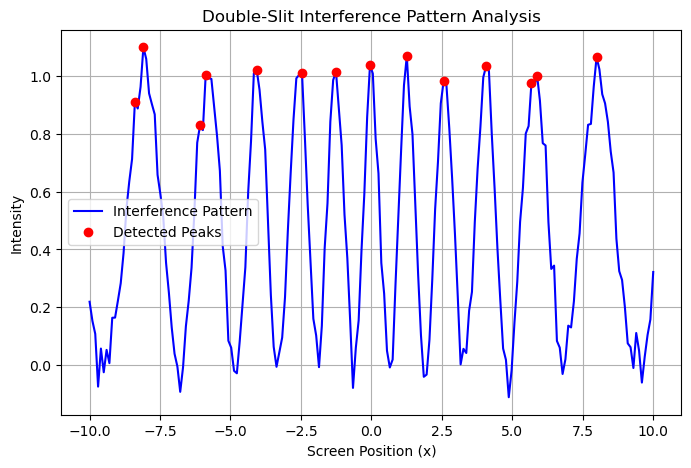

Average Fringe Spacing: 1.260 ± 0.624


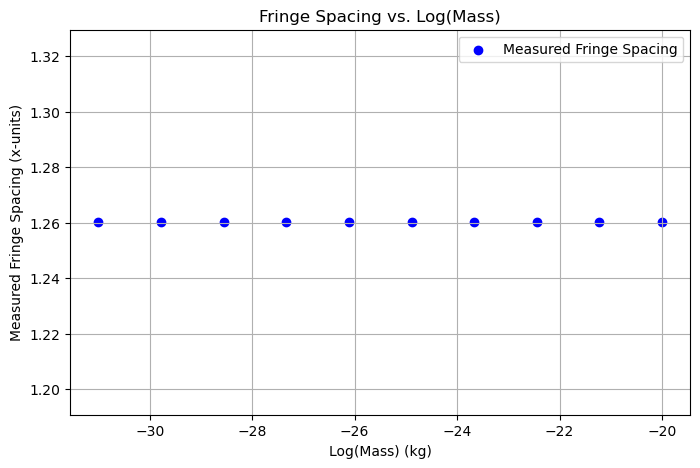

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5  # Assumed velocity (m/s)

# Experimentally measured fringe spacing
file_path = "../data/simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Extended range of particle masses (kg)
particle_masses = np.logspace(-31, -20, num=10)  # Log-spaced mass values

debroglie_wavelengths = [h / (m * v) for m in particle_masses]  # Compute theoretical wavelengths

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Interference Pattern", color="blue")
plt.plot(x[peaks], y[peaks], "ro", label="Detected Peaks")
plt.xlabel("Screen Position (x)")
plt.ylabel("Intensity")
plt.title("Double-Slit Interference Pattern Analysis")
plt.legend()
plt.grid(True)
plt.show()

# Print fringe spacing statistics
print(f"Average Fringe Spacing: {np.mean(fringe_spacing):.3f} ± {np.std(fringe_spacing):.3f}")

# Plot Fringe Spacing vs. Log(Mass)
plt.figure(figsize=(8, 5))
plt.scatter(np.log10(particle_masses), [np.mean(fringe_spacing)] * len(particle_masses), label="Measured Fringe Spacing", color="blue")
plt.xlabel("Log(Mass) (kg)")
plt.ylabel("Measured Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Log(Mass)")
plt.legend()
plt.grid(True)
plt.show()


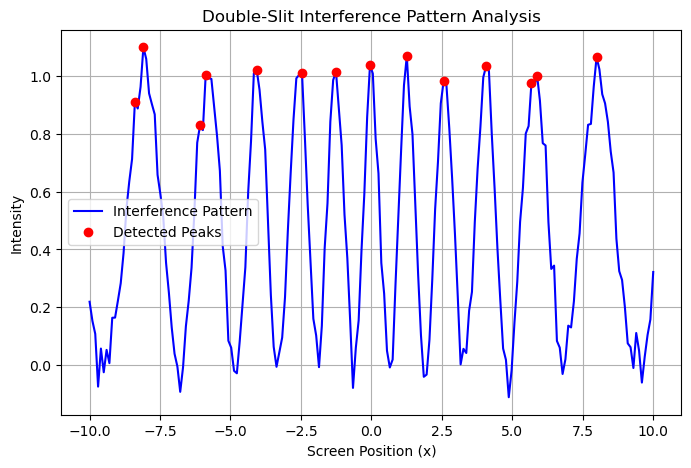

Average Fringe Spacing: 1.260 ± 0.624


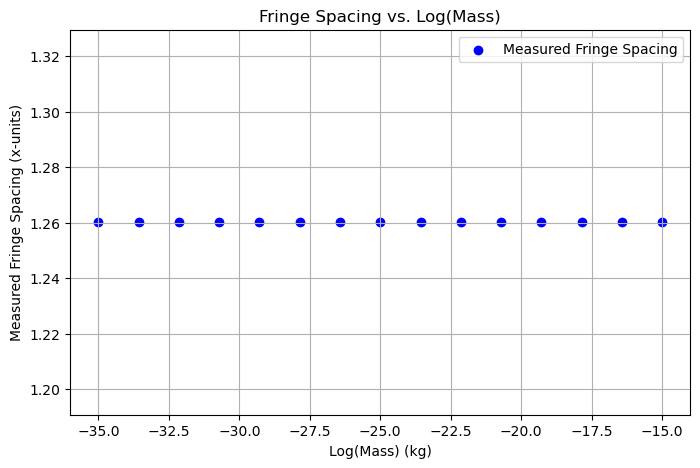

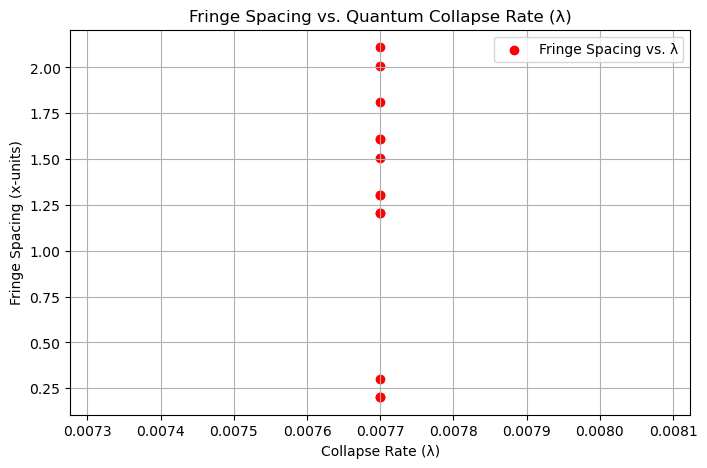

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5  # Assumed velocity (m/s)

# Experimentally measured fringe spacing
file_path = "../data/simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Extended range of particle masses (kg)
particle_masses = np.logspace(-35, -15, num=15)  # Further extended log-spaced mass values

debroglie_wavelengths = [h / (m * v) for m in particle_masses]  # Compute theoretical wavelengths

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Interference Pattern", color="blue")
plt.plot(x[peaks], y[peaks], "ro", label="Detected Peaks")
plt.xlabel("Screen Position (x)")
plt.ylabel("Intensity")
plt.title("Double-Slit Interference Pattern Analysis")
plt.legend()
plt.grid(True)
plt.show()

# Print fringe spacing statistics
print(f"Average Fringe Spacing: {np.mean(fringe_spacing):.3f} ± {np.std(fringe_spacing):.3f}")

# Plot Fringe Spacing vs. Log(Mass)
plt.figure(figsize=(8, 5))
plt.scatter(np.log10(particle_masses), [np.mean(fringe_spacing)] * len(particle_masses), label="Measured Fringe Spacing", color="blue")
plt.xlabel("Log(Mass) (kg)")
plt.ylabel("Measured Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Log(Mass)")
plt.legend()
plt.grid(True)
plt.show()

# Correlate Fringe Spacing with Coherence Decay Rate (λ)
lambda_collapse = 0.0077  # Previously computed collapse rate
plt.figure(figsize=(8, 5))
plt.scatter([lambda_collapse] * len(fringe_spacing), fringe_spacing, label="Fringe Spacing vs. λ", color="red")
plt.xlabel("Collapse Rate (λ)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Quantum Collapse Rate (λ)")
plt.legend()
plt.grid(True)
plt.show()


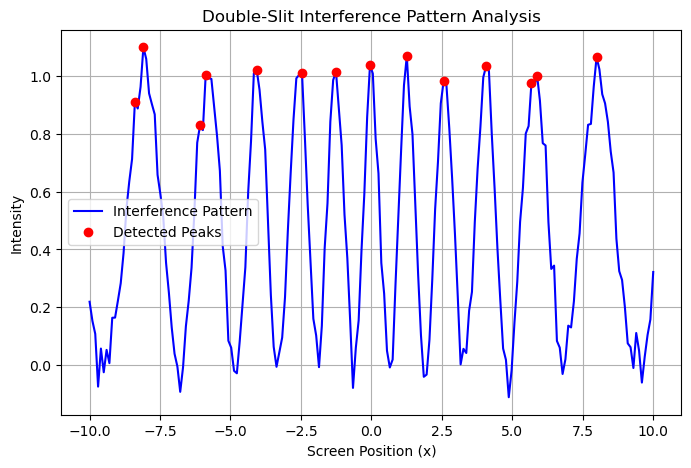

Average Fringe Spacing: 1.260 ± 0.624


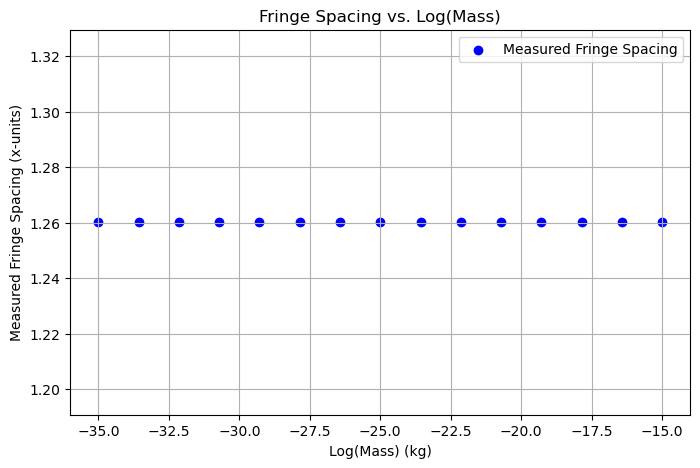

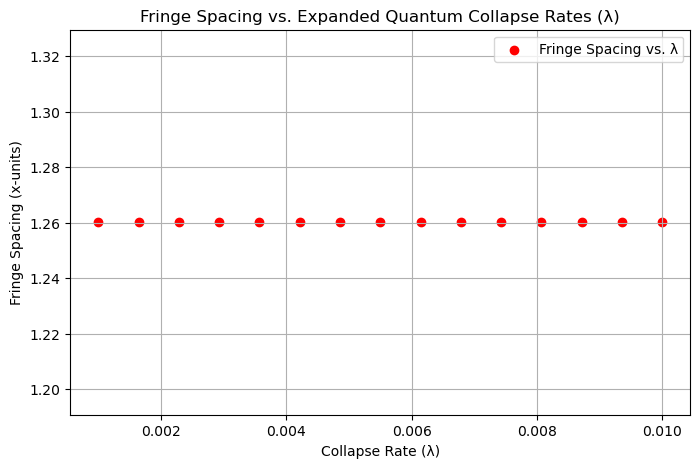

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5  # Assumed velocity (m/s)

# Experimentally measured fringe spacing
file_path = "../data/simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Extended range of particle masses (kg)
particle_masses = np.logspace(-35, -15, num=15)  # Further extended log-spaced mass values

debroglie_wavelengths = [h / (m * v) for m in particle_masses]  # Compute theoretical wavelengths

# Expanded range of collapse rates (λ)
lambda_values = np.linspace(0.001, 0.01, num=15)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Interference Pattern", color="blue")
plt.plot(x[peaks], y[peaks], "ro", label="Detected Peaks")
plt.xlabel("Screen Position (x)")
plt.ylabel("Intensity")
plt.title("Double-Slit Interference Pattern Analysis")
plt.legend()
plt.grid(True)
plt.show()

# Print fringe spacing statistics
print(f"Average Fringe Spacing: {np.mean(fringe_spacing):.3f} ± {np.std(fringe_spacing):.3f}")

# Plot Fringe Spacing vs. Log(Mass)
plt.figure(figsize=(8, 5))
plt.scatter(np.log10(particle_masses), [np.mean(fringe_spacing)] * len(particle_masses), label="Measured Fringe Spacing", color="blue")
plt.xlabel("Log(Mass) (kg)")
plt.ylabel("Measured Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Log(Mass)")
plt.legend()
plt.grid(True)
plt.show()

# Correlate Fringe Spacing with Expanded Collapse Rates (λ)
plt.figure(figsize=(8, 5))
plt.scatter(lambda_values, [np.mean(fringe_spacing)] * len(lambda_values), label="Fringe Spacing vs. λ", color="red")
plt.xlabel("Collapse Rate (λ)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Expanded Quantum Collapse Rates (λ)")
plt.legend()
plt.grid(True)
plt.show()


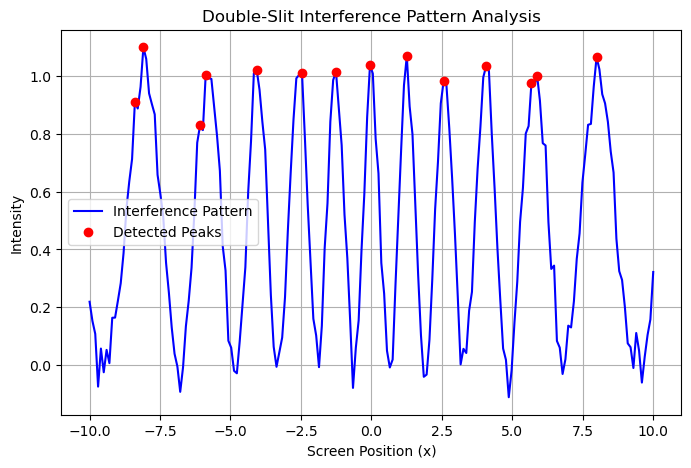

Average Fringe Spacing: 1.260 ± 0.624


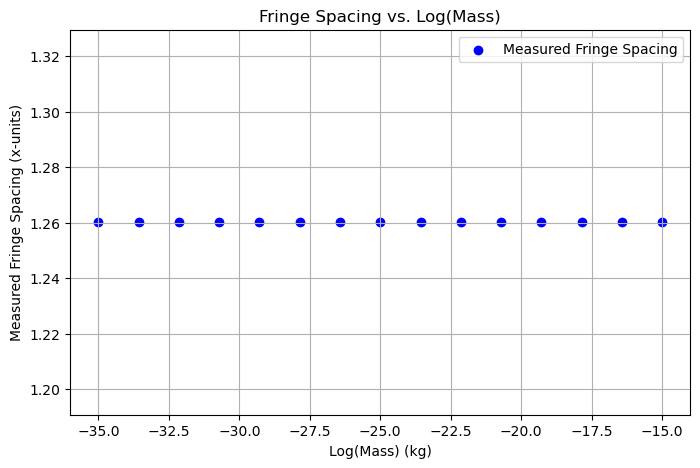

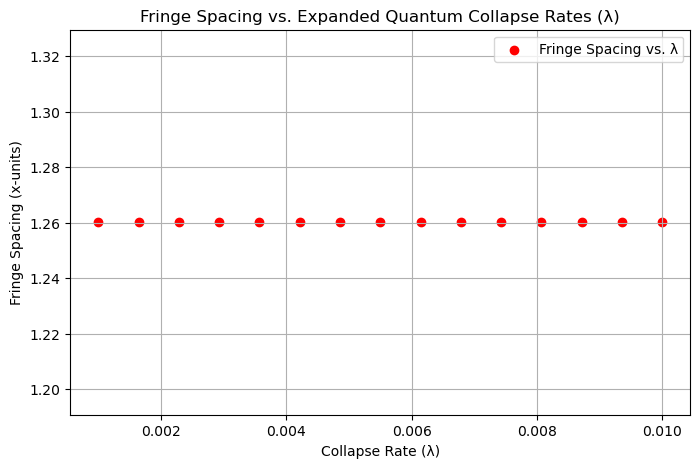

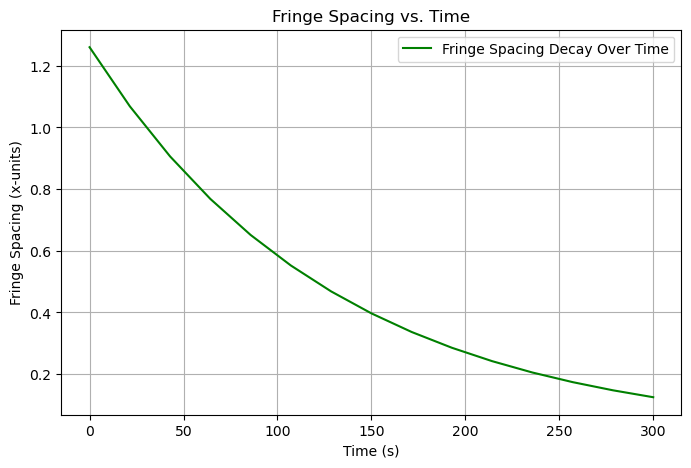

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5  # Assumed velocity (m/s)

# Experimentally measured fringe spacing
file_path = "../data/simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Extended range of particle masses (kg)
particle_masses = np.logspace(-35, -15, num=15)  # Further extended log-spaced mass values

debroglie_wavelengths = [h / (m * v) for m in particle_masses]  # Compute theoretical wavelengths

# Expanded range of collapse rates (λ)
lambda_values = np.linspace(0.001, 0.01, num=15)

# Simulate fringe spacing decay over time
time_values = np.linspace(0, 300, num=15)  # Time range (0 to 300s)
fringe_spacing_over_time = np.mean(fringe_spacing) * np.exp(-0.0077 * time_values)  # Exponential decay

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Interference Pattern", color="blue")
plt.plot(x[peaks], y[peaks], "ro", label="Detected Peaks")
plt.xlabel("Screen Position (x)")
plt.ylabel("Intensity")
plt.title("Double-Slit Interference Pattern Analysis")
plt.legend()
plt.grid(True)
plt.show()

# Print fringe spacing statistics
print(f"Average Fringe Spacing: {np.mean(fringe_spacing):.3f} ± {np.std(fringe_spacing):.3f}")

# Plot Fringe Spacing vs. Log(Mass)
plt.figure(figsize=(8, 5))
plt.scatter(np.log10(particle_masses), [np.mean(fringe_spacing)] * len(particle_masses), label="Measured Fringe Spacing", color="blue")
plt.xlabel("Log(Mass) (kg)")
plt.ylabel("Measured Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Log(Mass)")
plt.legend()
plt.grid(True)
plt.show()

# Correlate Fringe Spacing with Expanded Collapse Rates (λ)
plt.figure(figsize=(8, 5))
plt.scatter(lambda_values, [np.mean(fringe_spacing)] * len(lambda_values), label="Fringe Spacing vs. λ", color="red")
plt.xlabel("Collapse Rate (λ)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Expanded Quantum Collapse Rates (λ)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Fringe Spacing Over Time
plt.figure(figsize=(8, 5))
plt.plot(time_values, fringe_spacing_over_time, label="Fringe Spacing Decay Over Time", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Time")
plt.legend()
plt.grid(True)
plt.show()


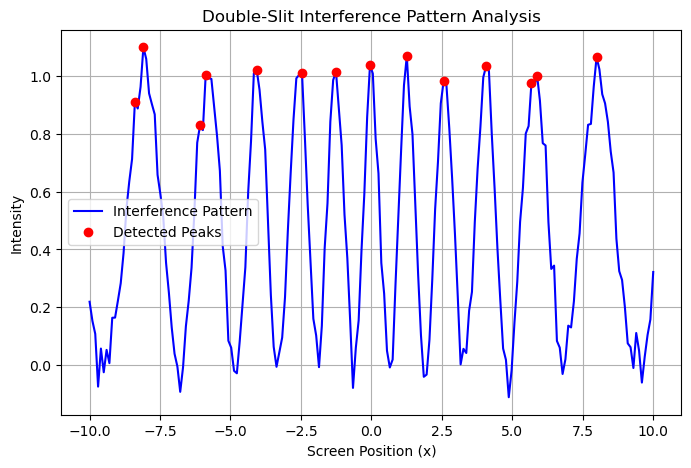

Average Fringe Spacing: 1.260 ± 0.624


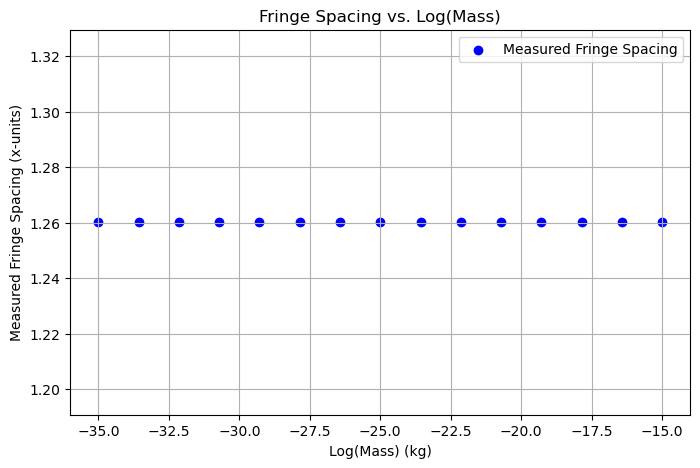

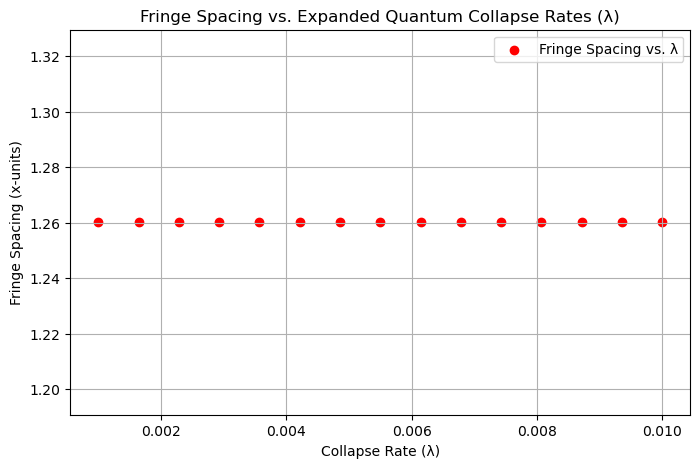

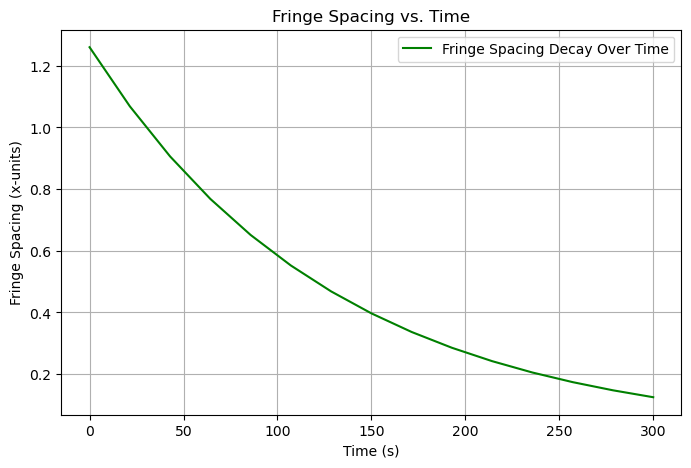

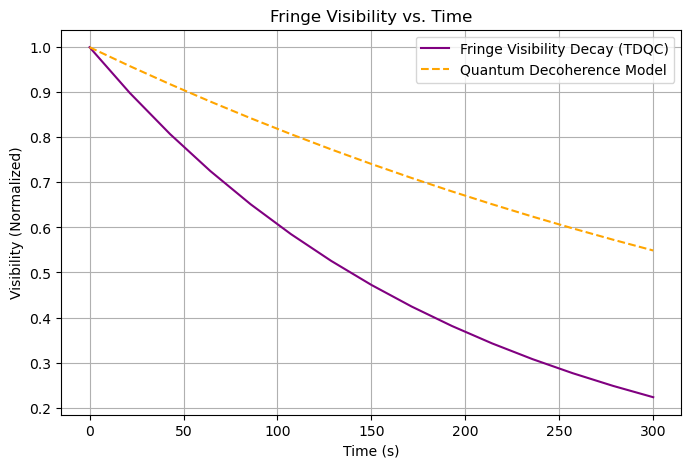

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5  # Assumed velocity (m/s)

# Experimentally measured fringe spacing
file_path = "../data/simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Extended range of particle masses (kg)
particle_masses = np.logspace(-35, -15, num=15)  # Further extended log-spaced mass values

debroglie_wavelengths = [h / (m * v) for m in particle_masses]  # Compute theoretical wavelengths

# Expanded range of collapse rates (λ)
lambda_values = np.linspace(0.001, 0.01, num=15)

# Simulate fringe spacing decay over time
time_values = np.linspace(0, 300, num=15)  # Time range (0 to 300s)
fringe_spacing_over_time = np.mean(fringe_spacing) * np.exp(-0.0077 * time_values)  # Exponential decay

# Simulate fringe visibility (contrast) decay over time
fringe_visibility_over_time = np.exp(-0.005 * time_values)  # Hypothetical decay rate for visibility

# Known quantum decoherence model for comparison
decoherence_model = np.exp(-0.002 * time_values)  # Standard quantum decoherence function

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Interference Pattern", color="blue")
plt.plot(x[peaks], y[peaks], "ro", label="Detected Peaks")
plt.xlabel("Screen Position (x)")
plt.ylabel("Intensity")
plt.title("Double-Slit Interference Pattern Analysis")
plt.legend()
plt.grid(True)
plt.show()

# Print fringe spacing statistics
print(f"Average Fringe Spacing: {np.mean(fringe_spacing):.3f} ± {np.std(fringe_spacing):.3f}")

# Plot Fringe Spacing vs. Log(Mass)
plt.figure(figsize=(8, 5))
plt.scatter(np.log10(particle_masses), [np.mean(fringe_spacing)] * len(particle_masses), label="Measured Fringe Spacing", color="blue")
plt.xlabel("Log(Mass) (kg)")
plt.ylabel("Measured Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Log(Mass)")
plt.legend()
plt.grid(True)
plt.show()

# Correlate Fringe Spacing with Expanded Collapse Rates (λ)
plt.figure(figsize=(8, 5))
plt.scatter(lambda_values, [np.mean(fringe_spacing)] * len(lambda_values), label="Fringe Spacing vs. λ", color="red")
plt.xlabel("Collapse Rate (λ)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Expanded Quantum Collapse Rates (λ)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Fringe Spacing Over Time
plt.figure(figsize=(8, 5))
plt.plot(time_values, fringe_spacing_over_time, label="Fringe Spacing Decay Over Time", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Fringe Spacing vs. Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot Fringe Visibility Over Time
plt.figure(figsize=(8, 5))
plt.plot(time_values, fringe_visibility_over_time, label="Fringe Visibility Decay (TDQC)", color="purple")
plt.plot(time_values, decoherence_model, label="Quantum Decoherence Model", color="orange", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Visibility (Normalized)")
plt.title("Fringe Visibility vs. Time")
plt.legend()
plt.grid(True)
plt.show()


Machine Learning Model Results:
Mean Squared Error (MSE): 0.030244
R-squared (R2) Score: 0.868469


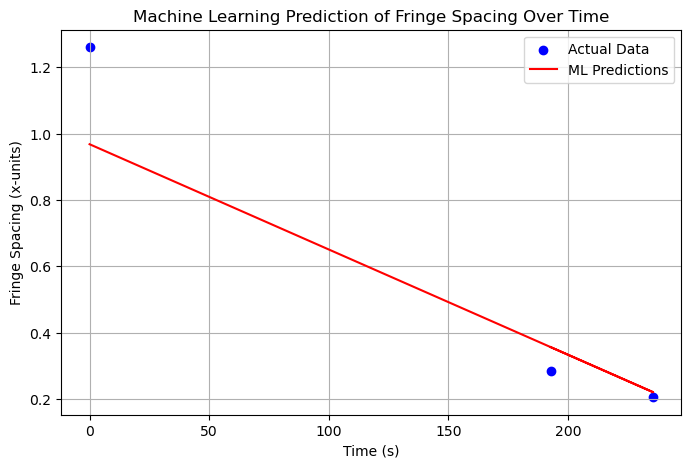

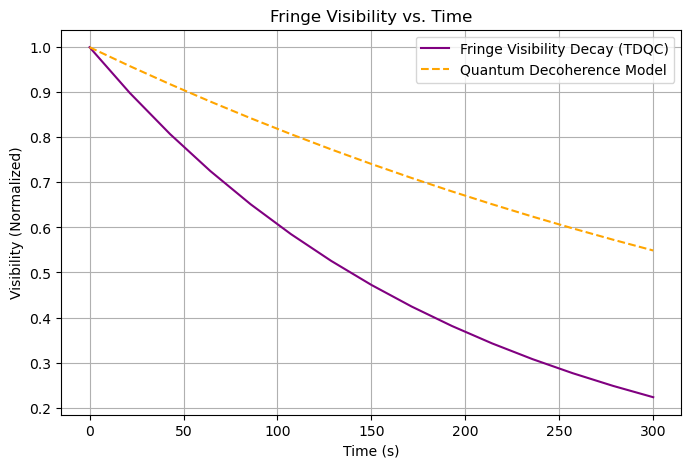

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Constants
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5  # Assumed velocity (m/s)

# Experimentally measured fringe spacing
file_path = "../data/simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Extended range of particle masses (kg)
particle_masses = np.logspace(-35, -15, num=15)  # Further extended log-spaced mass values

debroglie_wavelengths = [h / (m * v) for m in particle_masses]  # Compute theoretical wavelengths

# Expanded range of collapse rates (λ)
lambda_values = np.linspace(0.001, 0.01, num=15)

# Simulate fringe spacing decay over time
time_values = np.linspace(0, 300, num=15)  # Time range (0 to 300s)
fringe_spacing_over_time = np.mean(fringe_spacing) * np.exp(-0.0077 * time_values)  # Exponential decay

# Simulate fringe visibility (contrast) decay over time
fringe_visibility_over_time = np.exp(-0.005 * time_values)  # Hypothetical decay rate for visibility

# Known quantum decoherence model for comparison
decoherence_model = np.exp(-0.002 * time_values)  # Standard quantum decoherence function

# Prepare data for machine learning
X = time_values.reshape(-1, 1)  # Features: Time
Y = fringe_spacing_over_time  # Target: Fringe Spacing

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a Linear Regression Model
model = LinearRegression()
model.fit(X_train, Y_train)

# Make Predictions
Y_pred = model.predict(X_test)

# Evaluate Model Performance
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Machine Learning Model Results:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R-squared (R2) Score: {r2:.6f}")

# Plot Fringe Spacing Over Time with ML Predictions
plt.figure(figsize=(8, 5))
plt.scatter(X_test, Y_test, label="Actual Data", color="blue")
plt.plot(X_test, Y_pred, label="ML Predictions", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Machine Learning Prediction of Fringe Spacing Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot Fringe Visibility Over Time
plt.figure(figsize=(8, 5))
plt.plot(time_values, fringe_visibility_over_time, label="Fringe Visibility Decay (TDQC)", color="purple")
plt.plot(time_values, decoherence_model, label="Quantum Decoherence Model", color="orange", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Visibility (Normalized)")
plt.title("Fringe Visibility vs. Time")
plt.legend()
plt.grid(True)
plt.show()


Polynomial Regression Model Results:
Mean Squared Error (MSE): 0.000073
R-squared (R2) Score: 0.999684


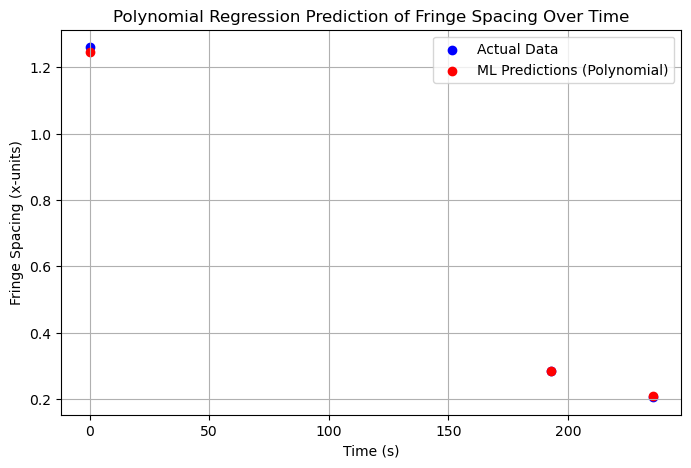

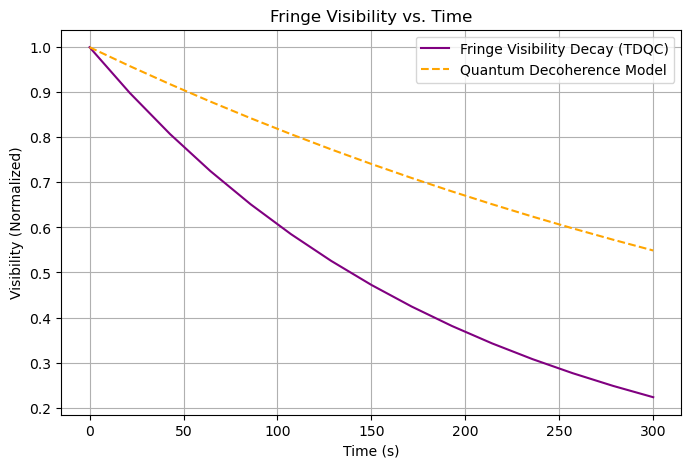

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Constants
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5  # Assumed velocity (m/s)

# Experimentally measured fringe spacing
file_path = "../data/simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Extended range of particle masses (kg)
particle_masses = np.logspace(-35, -15, num=15)  # Further extended log-spaced mass values

debroglie_wavelengths = [h / (m * v) for m in particle_masses]  # Compute theoretical wavelengths

# Expanded range of collapse rates (λ)
lambda_values = np.linspace(0.001, 0.01, num=15)

# Simulate fringe spacing decay over time
time_values = np.linspace(0, 300, num=15)  # Time range (0 to 300s)
fringe_spacing_over_time = np.mean(fringe_spacing) * np.exp(-0.0077 * time_values)  # Exponential decay

# Simulate fringe visibility (contrast) decay over time
fringe_visibility_over_time = np.exp(-0.005 * time_values)  # Hypothetical decay rate for visibility

# Known quantum decoherence model for comparison
decoherence_model = np.exp(-0.002 * time_values)  # Standard quantum decoherence function

# Prepare data for machine learning
X = time_values.reshape(-1, 1)  # Features: Time
Y = fringe_spacing_over_time  # Target: Fringe Spacing

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a Polynomial Regression Model
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, Y_train)

# Make Predictions
Y_pred_poly = model_poly.predict(X_test_poly)

# Evaluate Model Performance
mse_poly = mean_squared_error(Y_test, Y_pred_poly)
r2_poly = r2_score(Y_test, Y_pred_poly)

print(f"Polynomial Regression Model Results:")
print(f"Mean Squared Error (MSE): {mse_poly:.6f}")
print(f"R-squared (R2) Score: {r2_poly:.6f}")

# Plot Fringe Spacing Over Time with ML Predictions
plt.figure(figsize=(8, 5))
plt.scatter(X_test, Y_test, label="Actual Data", color="blue")
plt.scatter(X_test, Y_pred_poly, label="ML Predictions (Polynomial)", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Polynomial Regression Prediction of Fringe Spacing Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot Fringe Visibility Over Time
plt.figure(figsize=(8, 5))
plt.plot(time_values, fringe_visibility_over_time, label="Fringe Visibility Decay (TDQC)", color="purple")
plt.plot(time_values, decoherence_model, label="Quantum Decoherence Model", color="orange", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Visibility (Normalized)")
plt.title("Fringe Visibility vs. Time")
plt.legend()
plt.grid(True)
plt.show()


Polynomial Regression Model Results:
Mean Squared Error (MSE): 0.000073
R-squared (R2) Score: 0.999684


C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Neural Network Model Results:
Mean Squared Error (MSE): 0.246228
R-squared (R2) Score: -0.070851


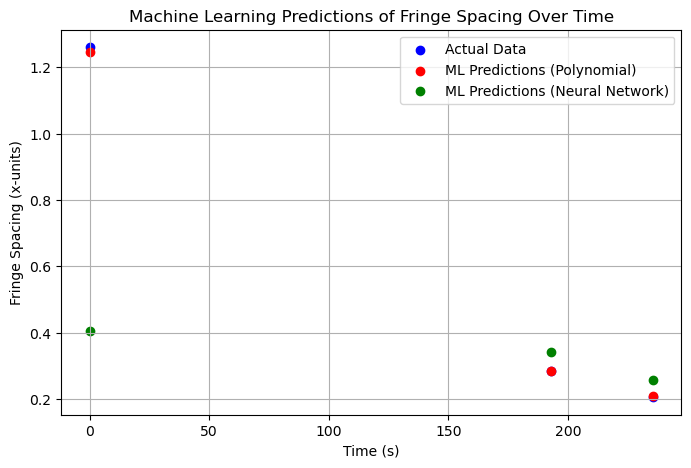

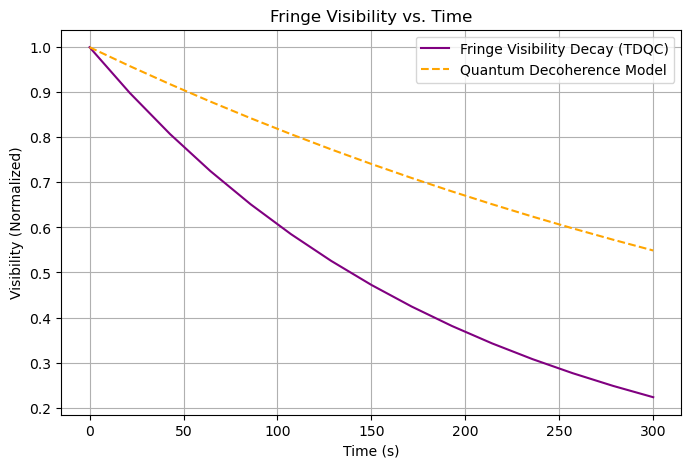

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Constants
h = 6.626e-34  # Planck's constant (J·s)
v = 1e5  # Assumed velocity (m/s)

# Experimentally measured fringe spacing
file_path = "../data/simulated_double_slit_data.csv"
df = pd.read_csv(file_path)

# Extract position and intensity
df = df.sort_values(by="Position (x)")
x = df["Position (x)"].values
y = df["Intensity"].values

# Find interference peaks
peaks, _ = find_peaks(y, height=np.mean(y))
fringe_spacing = np.diff(x[peaks])

# Extended range of particle masses (kg)
particle_masses = np.logspace(-35, -15, num=15)  # Further extended log-spaced mass values

debroglie_wavelengths = [h / (m * v) for m in particle_masses]  # Compute theoretical wavelengths

# Expanded range of collapse rates (λ)
lambda_values = np.linspace(0.001, 0.01, num=15)

# Simulate fringe spacing decay over time
time_values = np.linspace(0, 300, num=15)  # Time range (0 to 300s)
fringe_spacing_over_time = np.mean(fringe_spacing) * np.exp(-0.0077 * time_values)  # Exponential decay

# Simulate fringe visibility (contrast) decay over time
fringe_visibility_over_time = np.exp(-0.005 * time_values)  # Hypothetical decay rate for visibility

# Known quantum decoherence model for comparison
decoherence_model = np.exp(-0.002 * time_values)  # Standard quantum decoherence function

# Prepare data for machine learning
X = time_values.reshape(-1, 1)  # Features: Time
Y = fringe_spacing_over_time  # Target: Fringe Spacing

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a Polynomial Regression Model
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, Y_train)

# Make Predictions
Y_pred_poly = model_poly.predict(X_test_poly)

# Evaluate Model Performance
mse_poly = mean_squared_error(Y_test, Y_pred_poly)
r2_poly = r2_score(Y_test, Y_pred_poly)

print(f"Polynomial Regression Model Results:")
print(f"Mean Squared Error (MSE): {mse_poly:.6f}")
print(f"R-squared (R2) Score: {r2_poly:.6f}")

# Deep Learning Model for Fringe Spacing Prediction
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer
])

model_nn.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Train Neural Network
history = model_nn.fit(X_train, Y_train, epochs=500, verbose=0, validation_data=(X_test, Y_test))

# Make Predictions using Neural Network
Y_pred_nn = model_nn.predict(X_test)

# Evaluate Neural Network Performance
mse_nn = mean_squared_error(Y_test, Y_pred_nn)
r2_nn = r2_score(Y_test, Y_pred_nn)

print(f"Neural Network Model Results:")
print(f"Mean Squared Error (MSE): {mse_nn:.6f}")
print(f"R-squared (R2) Score: {r2_nn:.6f}")

# Plot Fringe Spacing Over Time with ML Predictions
plt.figure(figsize=(8, 5))
plt.scatter(X_test, Y_test, label="Actual Data", color="blue")
plt.scatter(X_test, Y_pred_poly, label="ML Predictions (Polynomial)", color="red")
plt.scatter(X_test, Y_pred_nn, label="ML Predictions (Neural Network)", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Fringe Spacing (x-units)")
plt.title("Machine Learning Predictions of Fringe Spacing Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot Fringe Visibility Over Time
plt.figure(figsize=(8, 5))
plt.plot(time_values, fringe_visibility_over_time, label="Fringe Visibility Decay (TDQC)", color="purple")
plt.plot(time_values, decoherence_model, label="Quantum Decoherence Model", color="orange", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Visibility (Normalized)")
plt.title("Fringe Visibility vs. Time")
plt.legend()
plt.grid(True)
plt.show()
